In [81]:
import wandb
from tqdm.notebook import tqdm

api = wandb.Api(timeout=19)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Fast Spike

In [172]:
run = api.run("ai2-llm/olmo-medium/adpt1srg")
steps = []
values = []
for data in tqdm(run.scan_history(keys=["_step", "train/CrossEntropyLoss"], min_step=57500, max_step=58500)):
    steps.append(data["_step"])
    values.append(data["train/CrossEntropyLoss"])

0it [00:00, ?it/s]

57500
58499


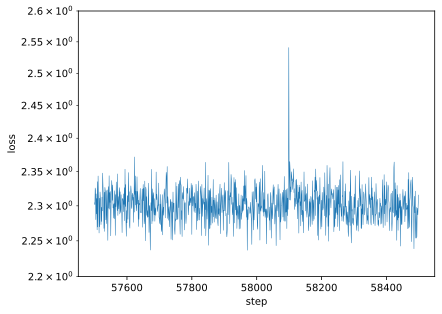

In [174]:
assert all(x > 0 for x in values)
print(min(steps))
print(max(steps))

fig, ax = plt.subplots()
ax.plot(steps, values, linewidth=0.5)
ax.set_ylim(2.2, 2.6)
plt.yscale('log')
plt.xlabel("step")
plt.ylabel("loss")
fig.savefig("fastspike.pdf", format="pdf")
plt.show()

## Slow Spike

In [84]:
run = api.run("ai2-llm/olmo-medium/yrd002s9")
steps = []
values = []
for data in tqdm(run.scan_history(keys=["_step", "train/CrossEntropyLoss"], min_step=2600, max_step=3500)):
    steps.append(data["_step"])
    values.append(data["train/CrossEntropyLoss"])

2600
3499


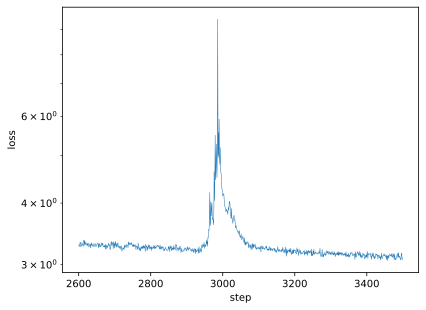

In [85]:
assert all(x > 0 for x in values)
print(min(steps))
print(max(steps))

fig, ax = plt.subplots()
ax.plot(steps, values, linewidth=0.5)
plt.yscale('log')
plt.xlabel("step")
plt.ylabel("loss")
fig.savefig("slowspike.pdf", format="pdf")
plt.show()

## Mitchish Grad Norm

In [86]:
runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": "mitchish7"}, order="created_at")
grad_norm_values = {}
for run in runs:
    for data in tqdm(run.scan_history(keys=["_step", "optim/total_grad_norm"])):
        grad_norm_values[data["_step"]] = data["optim/total_grad_norm"]
steps = list(grad_norm_values.keys())
values = list(grad_norm_values.values())
del grad_norm_values


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

10
639660


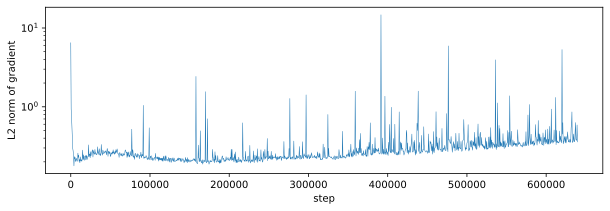

In [96]:
assert all(x > 0 for x in values)
print(min(steps))
print(max(steps))

import numpy as np
steps_np = np.array(steps)
values_np = np.array(values)
order = steps_np.argsort()
steps_np = steps_np[order]
values_np = values_np[order]
steps_np = steps_np[::50]
values_np = values_np[::50]

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(steps_np, values_np, linewidth=0.5)
plt.yscale('log')
plt.xlabel("step")
plt.ylabel("L2 norm of gradient")
fig.savefig("mitchish7gnorm.pdf", format="pdf")
plt.show()

## Data filter figure

In [ ]:
# Dustin is doing it.

## Initialization

In [112]:
wandb_groups = [
    #"llamaish7-dirk-baseline-normal-init",
    #"llamaish7-EmbInitFix-nogcwu-0",
    "llm-306-amber-data-repro-match-dirk-baseline",
    "llm-306-amber-data-repro-match-dirk-baseline-normal-init"
]
metric_names = ["train/CrossEntropyLoss", "optim/total_grad_norm"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}
max_step = float("inf")
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
    group_max_step = 0
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000):
            step = int(data["_step"])
            group_max_step = max(group_max_step, step)
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]
    max_step = min(max_step, group_max_step)
    del group_max_step

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [113]:
# postprocess
for key, d in metrics.items():
    metrics[key] = {
        step : value
        for step, value in sorted(d.items())
        if step <= max_step
    }

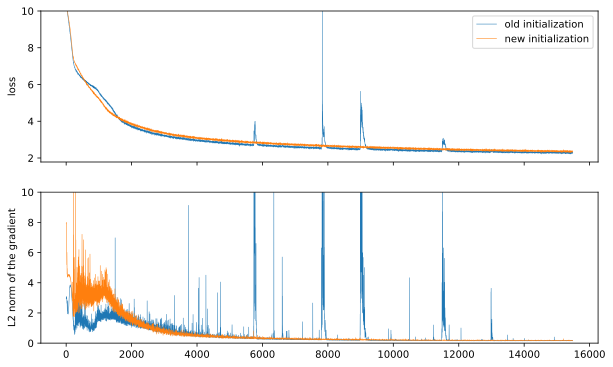

In [123]:
metric_name_map = {
    "train/CrossEntropyLoss": "loss",
    "optim/total_grad_norm": "L2 norm of the gradient"
}
group_name_map = {
    "llamaish7-dirk-baseline-normal-init": "old initialization",
    "llamaish7-EmbInitFix-nogcwu-0": "new initialization",
    "llm-306-amber-data-repro-match-dirk-baseline": "old initialization",
    "llm-306-amber-data-repro-match-dirk-baseline-normal-init": "new initialization",
}

fig, axs = plt.subplots(len(metric_names), sharex=True, figsize=(10, 6))
for metric_name, ax in zip(metric_names, axs):
    group_to_values = {}
    group_to_steps = {}
    for (group_name, inner_metric_name), values in metrics.items():
        if inner_metric_name != metric_name:
            continue
        steps = list(values.keys())
        values = list(values.values())

        group_to_values[group_name] = values
        group_to_steps[group_name] = steps
        ax.plot(steps, values, linewidth=0.5, label=group_name_map[group_name])
        if "CrossEntropyLoss" in metric_name:
            ax.set_ylim([None, 10.0])
        if "total_grad_norm" in metric_name:
            ax.set_ylim([0, 10.0])
        ax.set_ylabel(metric_name_map[metric_name])
    if ax == axs[0]:
        ax.legend()

fig.savefig("inits.pdf", format="pdf")

In [129]:
# spikescore

def zscore(metric_series, window, thresh):
    rolling_win = np.lib.stride_tricks.sliding_window_view(metric_series, window)
    avg = rolling_win.mean(axis=1)
    std = rolling_win.std(axis=1)
    metric_series = metric_series[window // 2:]
    metric_series = metric_series[:rolling_win.shape[0]]
    z = (metric_series - avg) / std
    outliers = (z < -thresh) | (z > thresh)
    return z, avg, std, outliers

def spike_score(a, window=1000, thresh=5):
    z, avg, std, outliers = zscore(a, window, thresh)
    n_outliers = outliers.sum()
    return n_outliers / len(a) * 100

for (group, name), values in metrics.items():
    print(f"{group}\t{name}\t{spike_score(np.array(list(values.values())))}")

llm-306-amber-data-repro-match-dirk-baseline	train/CrossEntropyLoss	0.16144656118824668
llm-306-amber-data-repro-match-dirk-baseline-normal-init	train/CrossEntropyLoss	0.0
llm-306-amber-data-repro-match-dirk-baseline	optim/total_grad_norm	0.4003874717468518
llm-306-amber-data-repro-match-dirk-baseline-normal-init	optim/total_grad_norm	0.03228931223764934


## Adam eps

In [130]:
wandb_groups = [
    "amberish7-4096",
    "llamaish7-normal"
]
metric_names = ["train/CrossEntropyLoss", "optim/total_grad_norm"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}
max_step = float("inf")
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
    group_max_step = 0
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000):
            step = int(data["_step"])
            group_max_step = max(group_max_step, step)
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]
    max_step = min(max_step, group_max_step)
    del group_max_step

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [131]:
# postprocess
for key, d in metrics.items():
    metrics[key] = {
        step : value
        for step, value in sorted(d.items())
        if step <= max_step
    }

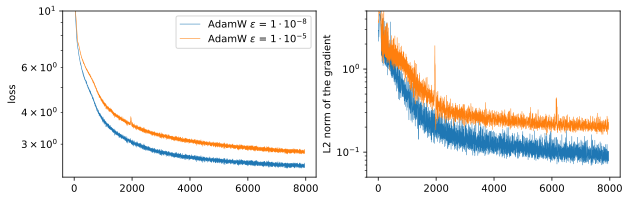

In [144]:
metric_name_map = {
    "train/CrossEntropyLoss": "loss",
    "optim/total_grad_norm": "L2 norm of the gradient"
}
group_name_map = {
    "llamaish7-normal": "AdamW $\epsilon$ = $1 \cdot 10^{-5}$",
    "amberish7-4096": "AdamW $\epsilon$ = $1 \cdot 10^{-8}$",
}

fig, axs = plt.subplots(1, len(metric_names), figsize=(10, 3))
for metric_name, ax in zip(metric_names, axs):
    group_to_values = {}
    group_to_steps = {}
    for (group_name, inner_metric_name), values in metrics.items():
        if inner_metric_name != metric_name:
            continue
        steps = list(values.keys())
        values = list(values.values())

        group_to_values[group_name] = values
        group_to_steps[group_name] = steps
        ax.semilogy(steps, values, linewidth=0.5, label=group_name_map[group_name])
        if "CrossEntropyLoss" in metric_name:
            ax.set_ylim([None, 10.0])
        if "total_grad_norm" in metric_name:
            ax.set_ylim([0.05, 5.0])
        ax.set_ylabel(metric_name_map[metric_name])
    if ax == axs[0]:
        ax.legend()

fig.savefig("adameps.pdf", format="pdf")

## Broken Z-Loss

In [152]:
wandb_group = "peteish13-highlr"

metric_names = ["train/ZLoss"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in [wandb_group, "broken_zloss"]
}
min_step = 440000
max_step = 520000
runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
for run in tqdm(runs):
    fixed_wandb_group = "broken_zloss" if "broken zloss" in run.name else wandb_group
    for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000, min_step=min_step, max_step=max_step):
        step = int(data["_step"])
        for metric_name in metric_names:
            value = data[metric_name]
            if value is not None:
                metrics[(fixed_wandb_group, metric_name)][step] = data[metric_name]


  0%|          | 0/108 [00:00<?, ?it/s]

In [157]:
# postprocess
min_step = 440000
max_step = 520000
for key, d in metrics.items():
    metrics[key] = {
        step : value
        for step, value in sorted(d.items())
        if min_step <= step <= max_step
    }

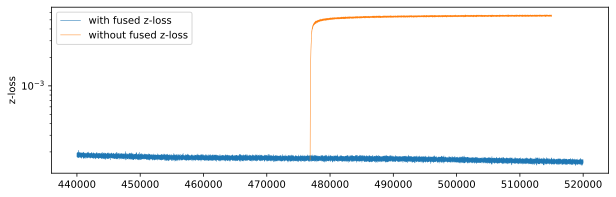

In [163]:
metric_name_map = {
    "train/ZLoss": "z-loss",
}
group_name_map = {
    wandb_group: "with fused z-loss",
    "broken_zloss": "without fused z-loss",
}

fig, axs = plt.subplots(1, len(metric_names), figsize=(10, 3))
axs = [axs]
for metric_name, ax in zip(metric_names, axs):
    group_to_values = {}
    group_to_steps = {}
    for (group_name, inner_metric_name), values in metrics.items():
        if inner_metric_name != metric_name:
            continue
        steps = list(values.keys())
        values = list(values.values())

        group_to_values[group_name] = values
        group_to_steps[group_name] = steps
        ax.semilogy(steps, values, linewidth=0.5, label=group_name_map[group_name])
        if "CrossEntropyLoss" in metric_name:
            ax.set_ylim([None, 10.0])
        if "total_grad_norm" in metric_name:
            ax.set_ylim([0.05, 5.0])
        ax.set_ylabel(metric_name_map[metric_name])
    if ax == axs[0]:
        ax.legend()

fig.savefig("zloss.pdf", format="pdf")

## Learning rates

In [226]:
wandb_groups = [
    "peteish7-xhighlr",
    "peteish7-highlr",
    "peteish7-medlr",
    "peteish7",
]
metric_names = ["train/CrossEntropyLoss"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}
max_step = None
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
    group_max_step = 0
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000, max_step=max_step):
            step = int(data["_step"])
            group_max_step = max(group_max_step, step)
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]
    max_step = group_max_step if max_step is None else min(max_step, group_max_step)
    del group_max_step

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [227]:
# postprocess
for key, d in metrics.items():
    metrics[key] = {
        step * 1024 * 4096 : value
        for step, value in sorted(d.items())
        if step <= max_step
    }

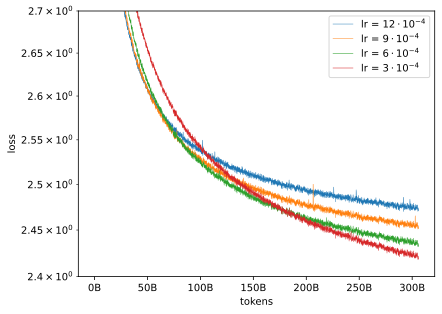

In [228]:
from matplotlib.ticker import FuncFormatter

metric_name_map = {
    "train/CrossEntropyLoss": "loss",
}
group_name_map = {
    "peteish7-xhighlr": "lr = $12 \cdot 10^{-4}$",
    "peteish7-highlr": "lr = $9 \cdot 10^{-4}$",
    "peteish7-medlr": "lr = $6 \cdot 10^{-4}$",
    "peteish7": "lr = $3 \cdot 10^{-4}$"
}

fig, axs = plt.subplots(1, len(metric_names))
axs = [axs]
for metric_name, ax in zip(metric_names, axs):
    for (group_name, inner_metric_name), values in metrics.items():
        if inner_metric_name != metric_name:
            continue
        steps = np.array(list(values.keys()))
        values = np.array(list(values.values()))

        window_size = 50
        y_smooth = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
        x_smooth = steps[:len(y_smooth)]

        ax.semilogy(x_smooth, y_smooth, linewidth=0.5, label=group_name_map[group_name])
        if "CrossEntropyLoss" in metric_name:
            ax.set_ylim([2.4, 2.7])
        if "total_grad_norm" in metric_name:
            ax.set_ylim([0.05, 5.0])
        ax.set_ylabel(metric_name_map[metric_name])
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e9:.0f}B"))
    ax.set_xlabel("tokens")
    if ax == axs[0]:
        ax.legend()

fig.savefig("learningrates.pdf", format="pdf")

## Learning Rate Anneals

In [229]:
regular_runs = [
    "peteish7-xhighlr",
    "peteish7-highlr",
    "peteish7-medlr",
    "peteish7-lowlr",
]
anneal_50b = [x + "-from72000" for x in regular_runs]
anneal_100b = [x + "-from72000-100e9" for x in regular_runs if x != "peteish7-lowlr"]
regular_runs[regular_runs.index("peteish7-lowlr")] = "peteish7"
wandb_groups = regular_runs + anneal_50b + anneal_100b

min_step = 65000

metric_names = ["train/CrossEntropyLoss"]
metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/olmo-medium", filters={"group": wandb_group}, order="created_at")
    if wandb_group in regular_runs:
        max_step = 72000
    else:
        max_step = None
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000, min_step=min_step, max_step=max_step):
            step = int(data["_step"])
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [230]:
# postprocess
for key, d in metrics.items():
    metrics[key] = {
        step * 1024 * 4096 : value
        for step, value in sorted(d.items())
    }

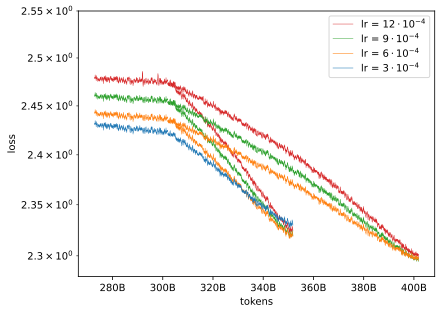

In [231]:
from matplotlib.ticker import FuncFormatter

metric_name_map = {
    "train/CrossEntropyLoss": "loss",
}
group_name_map = {
    "peteish7-xhighlr": "lr = $12 \cdot 10^{-4}$",
    "peteish7-highlr": "lr = $9 \cdot 10^{-4}$",
    "peteish7-medlr": "lr = $6 \cdot 10^{-4}$",
    "peteish7": "lr = $3 \cdot 10^{-4}$"
}

fig, axs = plt.subplots(1, len(metric_names))
axs = [axs]
for metric_name, ax in zip(metric_names, axs):
    for (group_name, inner_metric_name), values in metrics.items():
        if inner_metric_name != metric_name:
            continue
        steps = np.array(list(values.keys()))
        values = np.array(list(values.values()))

        window_size = 50
        y_smooth = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
        if group_name in regular_runs:
            x_smooth = steps[-len(y_smooth):]
        else:
            x_smooth = steps[:len(y_smooth)]

        if group_name.startswith("peteish7-xhighlr"):
            color = (0.839, 0.153, 0.157)
        elif group_name.startswith("peteish7-highlr"):
            color = (0.173, 0.627, 0.173)
        elif group_name.startswith("peteish7-medlr"):
            color =(1.000, 0.498, 0.055) # orange
        else:
            color = (0.121, 0.466, 0.705) # blue

        ax.semilogy(x_smooth, y_smooth, linewidth=0.5, label=group_name_map.get(group_name), color=color)
        ax.set_ylim([2.28, 2.55])
        ax.set_ylabel(metric_name_map[metric_name])
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e9:.0f}B"))
    ax.set_xlabel("tokens")
    if ax == axs[0]:
        ax.legend()

fig.savefig("learningrateanneals.pdf", format="pdf")